# Feature correlation

Correlation between main weapon used and various "features" of the round on different maps

In [4]:


from s2_analytics.filters import SIMILAR_WIN_PROB
import sqlite3

import pandas as pd
import seaborn as sns

from s2_analytics.collector.sqlite_collector import SqliteCollector
from s2_analytics.constants import WEAPONS_PRIMARY, WEAPONS_SECONDARY, WEAPON_MODS_DATES
from s2_analytics.importer import import_games
from s2_analytics.main_weapon_analyzer import MainWeaponRoundTagger
from s2_analytics.team_round_tag_correlation_analyzer import TeamRoundTagCorrelationAnalyzer
from s2_analytics.test_summary_collector import SummaryCollector

conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
tag_correlation_analyzer = TeamRoundTagCorrelationAnalyzer(conn, sqlite_collector, [
    MainWeaponRoundTagger([WEAPONS_PRIMARY])]).init()
import_games(
    "logs_ranked/",
    start_date=WEAPON_MODS_DATES[0],
    processors=[tag_correlation_analyzer, sqlite_collector],
    game_filters=[
        lambda g: g.playlist_code == "CTF-Standard-6",
        SIMILAR_WIN_PROB
    ]
)
pass

## Data summary

In [8]:
import tabulate

summary = summary_collector.get_summary().to_table()
tabulate.tabulate(summary, tablefmt='html')

First game,2022-12-28
Last game,2023-02-02
Games total,467
Rounds total,1195
Games in playlist `CTF-Standard-6`,467


## Weapon-victory correlation

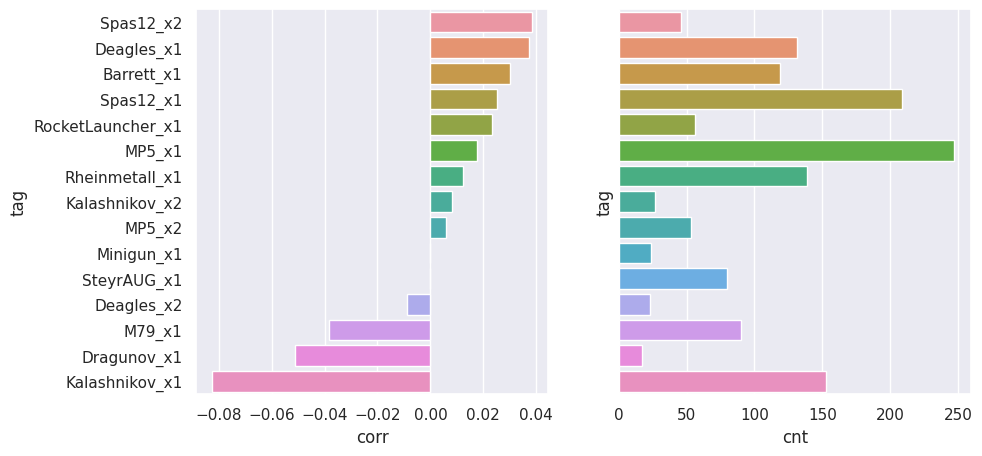

In [16]:
from matplotlib import pyplot as plt
from s2_analytics.test_main_weapon_analyzer import NO_RESULT_TAG_FILTER

correlation = tag_correlation_analyzer.calculate_win_correlation()

sns.set(rc={'figure.figsize': (5, 18)})
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

corr = pd.DataFrame(correlation.items(), columns=["tag", "corr"])
counts = tag_correlation_analyzer.tag_counts(NO_RESULT_TAG_FILTER)
cnts = pd.DataFrame(counts.items(), columns=["tag", "cnt"]).sort_values(by=["cnt"], ascending=False)
minimum_required_count = cnts.head(n=15)["cnt"].min()

merged = pd.merge(corr, cnts, on=["tag"])\
    .sort_values(by=["corr"], ascending=False)
merged = merged[merged["cnt"] >= minimum_required_count]
sns.barplot(x=merged["corr"], y=merged["tag"], ax=axes[0])
sns.barplot(x=merged["cnt"], y=merged["tag"], ax=axes[1])
pass